## Import stuff


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import time

# Input data files are available in the "../input/" directory.
import os
INPUTDIR = '../input/language-identification-datasst'
print(os.listdir(f'{INPUTDIR}'))

#Init random seed to get reproducible results
seed = 1111
random.seed(seed)
np.random.RandomState(seed)
torch.manual_seed(seed)

# Any results you write to the current directory are saved as output.
raw = pd.read_csv(f'{INPUTDIR}/dataset.csv', encoding='latin-1')
x_train_full = raw['Text']
y_train_full = raw['language']
print('Example:')
print('LANG =', y_train_full[0])
print('TEXT =', x_train_full[0])

['dataset.csv']
Example:
LANG = Estonian
TEXT = klement gottwaldi surnukeha palsameeriti ning paigutati mausoleumi surnukeha oli aga liiga hilja ja oskamatult palsameeritud ning hakkas ilmutama lagunemise tundemÃ¤rke  aastal viidi ta surnukeha mausoleumist Ã¤ra ja kremeeriti zlÃ­ni linn kandis aastatel â nime gottwaldov ukrainas harkivi oblastis kandis zmiivi linn aastatel â nime gotvald
Example:
LANG = Estonian
TEXT = klement gottwaldi surnukeha palsameeriti ning paigutati mausoleumi surnukeha oli aga liiga hilja ja oskamatult palsameeritud ning hakkas ilmutama lagunemise tundemÃ¤rke  aastal viidi ta surnukeha mausoleumist Ã¤ra ja kremeeriti zlÃ­ni linn kandis aastatel â nime gottwaldov ukrainas harkivi oblastis kandis zmiivi linn aastatel â nime gotvald


## Define the Dictionary

In [4]:
class Dictionary(object):
    def __init__(self):
        self.token2idx = {}
        self.idx2token = []

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def __len__(self):
        return len(self.idx2token)

The **Dictionary** class is used to map tokens (characters, words, subwords) into consecutive integer indexes.  
The index **0** is reserved for padding sequences up to a fixed lenght, and the index **1** for any 'unknown' character

In [5]:
char_vocab = Dictionary()
pad_token = '<pad>' # reserve index 0 for padding
unk_token = '<unk>' # reserve index 1 for unknown token
pad_index = char_vocab.add_token(pad_token)
unk_index = char_vocab.add_token(unk_token)

# join all the training sentences in a single string
# and obtain the list of different characters with set
chars = set(''.join(x_train_full))
for char in sorted(chars):
    char_vocab.add_token(char)
print("Vocabulary:", len(char_vocab), "UTF characters")

lang_vocab = Dictionary()
# use python set to obtain the list of languages without repetitions
languages = set(y_train_full)
for lang in sorted(languages):
    lang_vocab.add_token(lang)
print("Labels:", len(lang_vocab), "languages")

Vocabulary: 153 UTF characters
Labels: 22 languages


### Convert Text and Labels to Integer Indices
Map each character in the text samples to its vocabulary index, and each language label to its corresponding index. This transforms the raw text data into numerical format suitable for the neural network.

In [6]:
#From token or label to index
print('k ->', char_vocab.token2idx['k'])
print('Estonian ->', lang_vocab.token2idx['Estonian'])
print(y_train_full[0], x_train_full[0][:10])
x_train_idx = [np.array([char_vocab.token2idx[c] for c in line]) for line in x_train_full]
y_train_idx = np.array([lang_vocab.token2idx[lang] for lang in y_train_full])
print(y_train_idx[0], x_train_idx[0][:10])

k -> 26
Estonian -> 4
Estonian klement go
4 [26 27 20 28 20 29 35  2 22 30]
4 [26 27 20 28 20 29 35  2 22 30]


Radomly select 20% of the database for validation  
Create lists of (input, target) tuples for training and validation

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_idx, y_train_idx, test_size=0.2, random_state=42)
train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
print(len(train_data), "training samples")
print(len(val_data), "validation samples")

17600 training samples
4400 validation samples


In [8]:
def batch_generator(data, batch_size, token_size):
    """Yield elements from data in chunks with a maximum of batch_size sequences and token_size tokens."""
    minibatch, sequences_so_far, tokens_so_far = [], 0, 0
    for ex in data:
        seq_len = len(ex[0])
        if seq_len > token_size:
            ex = (ex[0][:token_size], ex[1])
            seq_len = token_size
        minibatch.append(ex)
        sequences_so_far += 1
        tokens_so_far += seq_len
        if sequences_so_far == batch_size or tokens_so_far == token_size:
            yield minibatch
            minibatch, sequences_so_far, tokens_so_far = [], 0, 0
        elif sequences_so_far > batch_size or tokens_so_far > token_size:
            yield minibatch[:-1]
            minibatch, sequences_so_far, tokens_so_far = minibatch[-1:], 1, len(minibatch[-1][0])
    if minibatch:
        yield minibatch

### Batch Generator
Creates mini-batches of data with constraints on both the number of sequences (`batch_size`) and total tokens (`token_size`). Sequences longer than `token_size` are truncated.

In [9]:
def pool_generator(data, batch_size, token_size, shuffle=False):
    """Sort within buckets, then batch, then shuffle batches.
    Partitions data into chunks of size 100*token_size, sorts examples within
    each chunk, then batch these examples and shuffle the batches.
    """
    for p in batch_generator(data, batch_size * 100, token_size * 100):
        p_batch = batch_generator(sorted(p, key=lambda t: len(t[0]), reverse=True), batch_size, token_size)
        p_list = list(p_batch)
        if shuffle:
            for b in random.sample(p_list, len(p_list)):
                yield b
        else:
            for b in p_list:
                yield b

### Pool Generator (Bucketed Batching)
Sorts sequences by length within buckets for efficient padding, then creates batches and optionally shuffles them. This minimizes wasted computation from padding shorter sequences.

**DNN Model**  
Includes Python comments with the dimension of the input  matrix:  
T = Max number of tokens in a sequence  
B = Number of sequences (batch size)  
E = Embedding dim  
H = Hidden size  
O = Output size (number of languages)

In [10]:
class CharRNNClassifier(torch.nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, output_size, model="lstm", num_layers=1, bidirectional=False, pad_idx=0):
        super().__init__()
        self.model = model.lower()
        self.hidden_size = hidden_size
        self.embed = torch.nn.Embedding(input_size, embedding_size, padding_idx=pad_idx)
        if self.model == "gru":
            self.rnn = torch.nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        elif self.model == "lstm":
            self.rnn = torch.nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, input, input_lengths):
        # T x B
        encoded = self.embed(input)
        # T x B x E
        packed = torch.nn.utils.rnn.pack_padded_sequence(encoded, input_lengths)
        # Packed T x B x E
        output, _ = self.rnn(packed)
        # Packed T x B x H
        # Important: you may need to replace '-inf' with the default zero padding for other pooling layers
        padded, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=float('-inf'))
        # T x B x H
        output, _ = padded.max(dim=0)
        # B x H
        output = self.h2o(output)
        # B x O
        return output

In [11]:
if not torch.cuda.is_available():
    print("WARNING: CUDA is not available. Select 'GPU On' on kernel settings")
device = torch.device("cuda")
torch.cuda.manual_seed(seed)

### Device Configuration
Check for CUDA (GPU) availability and set up the device for training. GPU acceleration significantly speeds up the training process.

The **nn.CrossEntropyLoss()** criterion combines **nn.LogSoftmax()** and **nn.NLLLoss()** in one single class.  
It is useful when training a classification problem.

In [12]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [13]:
def train(model, optimizer, data, batch_size, token_size, max_norm=1, log=False):
    model.train()
    total_loss = 0
    ncorrect = 0
    nsentences = 0
    ntokens = 0
    niterations = 0
    for batch in pool_generator(data, batch_size, token_size, shuffle=True):
        # Get input and target sequences from batch
        X = [torch.from_numpy(d[0]) for d in batch]
        X_lengths = [x.numel() for x in X]
        ntokens += sum(X_lengths)
        X_lengths = torch.tensor(X_lengths, dtype=torch.long)
        y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
        # Pad the input sequences to create a matrix
        X = torch.nn.utils.rnn.pad_sequence(X).to(device)
        model.zero_grad()
        output = model(X, X_lengths)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)      # Gradient clipping https://www.kaggle.com/c/wili4/discussion/231378
        optimizer.step()
        # Training statistics
        total_loss += loss.item()
        ncorrect += (torch.max(output, 1)[1] == y).sum().item()
        nsentences += y.numel()
        niterations += 1
    
    total_loss = total_loss / nsentences
    accuracy = 100 * ncorrect / nsentences
    if log:
        print(f'Train: wpb={ntokens//niterations}, bsz={nsentences//niterations}, num_updates={niterations}')
    return accuracy

### Training Function
Performs one epoch of training: iterates through batches, computes forward pass, calculates loss, performs backpropagation with gradient clipping, and updates model weights. Returns training accuracy.

In [14]:
def validate(model, data, batch_size, token_size):
    model.eval()
    # calculate accuracy on validation set
    ncorrect = 0
    nsentences = 0
    with torch.no_grad():
        for batch in pool_generator(data, batch_size, token_size):
            # Get input and target sequences from batch
            X = [torch.from_numpy(d[0]) for d in batch]
            X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long)
            y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
            # Pad the input sequences to create a matrix
            X = torch.nn.utils.rnn.pad_sequence(X).to(device)
            answer = model(X, X_lengths)
            ncorrect += (torch.max(answer, 1)[1] == y).sum().item()
            nsentences += y.numel()
        dev_acc = 100 * ncorrect / nsentences
    return dev_acc

### Validation Function
Evaluates the model on the validation set without updating weights (`torch.no_grad()`). Returns validation accuracy to monitor for overfitting.

In [61]:
hidden_size = 256
embedding_size = 64
bidirectional = False
ntokens = len(char_vocab)
nlabels = len(lang_vocab)

### Model Hyperparameters
Define the key hyperparameters: hidden layer size (256), embedding dimension (64), and whether to use bidirectional RNN. Also capture vocabulary sizes.

Model for cross-validation

In [15]:
def get_model():
    model = CharRNNClassifier(ntokens, embedding_size, hidden_size, nlabels, bidirectional=bidirectional, pad_idx=pad_index).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    return model, optimizer

In [66]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
batch_size, token_size = 16, 2048
epochs = 25
train_accuracy = []
valid_accuracy = []
model, optimizer = get_model()
print(f'Training cross-validation model for {epochs} epochs')
t0 = time.time()
for epoch in range(1, epochs + 1):
    acc = train(model, optimizer, train_data, batch_size, token_size, log=epoch==1)
    train_accuracy.append(acc)
    print(f'| epoch {epoch:03d} | train accuracy={acc:.1f}% ({time.time() - t0:.0f}s)')
    acc = validate(model, val_data, batch_size, token_size)
    valid_accuracy.append(acc)
    print(f'| epoch {epoch:03d} | valid accuracy={acc:.1f}%')

Training cross-validation model for 25 epochs
Train: wpb=1669, bsz=2, num_updates=6035
| epoch 001 | train accuracy=91.8% (399s)
Train: wpb=1669, bsz=2, num_updates=6035
| epoch 001 | train accuracy=91.8% (399s)
| epoch 001 | valid accuracy=97.0%
| epoch 001 | valid accuracy=97.0%
| epoch 002 | train accuracy=97.8% (840s)
| epoch 002 | train accuracy=97.8% (840s)
| epoch 002 | valid accuracy=97.9%
| epoch 002 | valid accuracy=97.9%
| epoch 003 | train accuracy=98.4% (1265s)
| epoch 003 | train accuracy=98.4% (1265s)
| epoch 003 | valid accuracy=98.0%
| epoch 003 | valid accuracy=98.0%
| epoch 004 | train accuracy=98.7% (1695s)
| epoch 004 | train accuracy=98.7% (1695s)
| epoch 004 | valid accuracy=98.0%
| epoch 004 | valid accuracy=98.0%
| epoch 005 | train accuracy=99.0% (2118s)
| epoch 005 | train accuracy=99.0% (2118s)
| epoch 005 | valid accuracy=98.3%
| epoch 005 | valid accuracy=98.3%
| epoch 006 | train accuracy=99.2% (2541s)
| epoch 006 | train accuracy=99.2% (2541s)
| epoch 00

### Training Loop
Train the model for 25 epochs, logging training and validation accuracy after each epoch. Uses batch size of 16 and token size of 2048.

In [16]:
print(model)
for name, param in model.named_parameters():
    print(f'{name:20} {param.numel()} {list(param.shape)}')
print(f'TOTAL                {sum(p.numel() for p in model.parameters())}')

NameError: name 'model' is not defined

### Model Architecture Summary
Display the model structure and count the total number of trainable parameters.

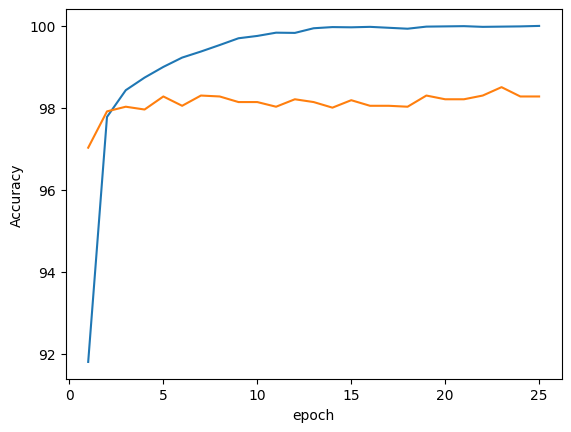

In [69]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(train_accuracy)+1), train_accuracy)
plt.plot(range(1, len(valid_accuracy)+1), valid_accuracy)
plt.xlabel('epoch')
plt.ylabel('Accuracy');

### Visualize Training Progress
Plot training and validation accuracy curves over epochs to assess model learning and potential overfitting.

## Save the Trained Model

Save the model so you can load it later without retraining.

In [71]:
# Save model and vocabularies
model_path = 'rnn_language_model.pt'

# Save everything needed for inference
torch.save({
    'model_state_dict': model.state_dict(),
    'char_vocab': char_vocab,
    'lang_vocab': lang_vocab,
    'hidden_size': hidden_size,
    'embedding_size': embedding_size,
    'bidirectional': bidirectional,
    'ntokens': ntokens,
    'nlabels': nlabels,
    'pad_index': pad_index,
    'train_accuracy': train_accuracy,
    'valid_accuracy': valid_accuracy,
}, model_path)

print(f"✅ Model saved to: {model_path}")

✅ Model saved to: rnn_language_model.pt


## Inference - Predict Language for Sample Text

Now that the model is trained, you can use it to predict the language of any text sample.

## Load the Saved Model

**Run this cell first** if you're starting a fresh notebook session and want to make predictions without retraining.

In [19]:
# Load the saved model
model_path = 'rnn_language_model.pt'

# Ensure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check if model file exists
if not os.path.exists(model_path):
    print(f"❌ Error: Model file '{model_path}' not found!")
    print("Please run the training cell and the save model cell first.")
else:
    # Load checkpoint (weights_only=False to load custom Dictionary objects)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Restore vocabularies
    char_vocab = checkpoint['char_vocab']
    lang_vocab = checkpoint['lang_vocab']
    
    # Restore model hyperparameters
    hidden_size = checkpoint['hidden_size']
    embedding_size = checkpoint['embedding_size']
    bidirectional = checkpoint['bidirectional']
    ntokens = checkpoint['ntokens']
    nlabels = checkpoint['nlabels']
    pad_index = checkpoint['pad_index']
    
    # Recreate the model
    model = CharRNNClassifier(
        ntokens, 
        embedding_size, 
        hidden_size, 
        nlabels, 
        bidirectional=bidirectional, 
        pad_idx=pad_index
    ).to(device)
    
    # Load the trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    
    print(f"✅ Model loaded successfully from: {model_path}")
    print(f"   Vocabulary: {len(char_vocab)} characters")
    print(f"   Languages: {len(lang_vocab)} languages")
    print(f"   Model ready for predictions!")

✅ Model loaded successfully from: rnn_language_model.pt
   Vocabulary: 153 characters
   Languages: 22 languages
   Model ready for predictions!


In [20]:
def predict_language(text, model, char_vocab, lang_vocab, max_len=512):
    """
    Predict the language of a given text using the trained RNN model.
    
    Args:
        text: Input text string to classify
        model: Trained CharRNNClassifier model
        char_vocab: Character vocabulary (Dictionary object)
        lang_vocab: Language vocabulary (Dictionary object)
        max_len: Maximum sequence length (default 512)
    
    Returns:
        predicted_language: The predicted language as a string
        confidence: Probability/confidence of the prediction (0-1)
        all_probs: Dictionary of all language probabilities
    """
    model.eval()
    
    # Convert text to character indices
    # Use unk_index (1) for any unknown characters
    char_indices = []
    for c in text[:max_len]:  # Truncate to max_len
        idx = char_vocab.token2idx.get(c, 1)  # 1 is unk_index
        char_indices.append(idx)
    
    # Convert to tensor
    X = torch.tensor(char_indices, dtype=torch.long).unsqueeze(1).to(device)  # (seq_len, 1)
    X_lengths = torch.tensor([len(char_indices)], dtype=torch.long)
    
    # Get prediction
    with torch.no_grad():
        output = model(X, X_lengths)  # (1, nlabels)
        probs = F.softmax(output, dim=1).squeeze().cpu().numpy()
    
    # Get predicted language
    predicted_idx = probs.argmax()
    predicted_lang = lang_vocab.idx2token[predicted_idx]
    confidence = float(probs[predicted_idx])
    
    # Create dictionary of all probabilities
    all_probs = {lang_vocab.idx2token[i]: float(probs[i]) for i in range(len(lang_vocab))}
    
    return predicted_lang, confidence, all_probs

print("✅ Prediction function defined!")

✅ Prediction function defined!


### Prediction Function
Converts input text to character indices, runs it through the model, and returns the predicted language with confidence scores for all classes.

In [21]:
# Test the prediction function with sample texts
test_samples = [
    "Hello, how are you doing today?",
    "Bonjour, comment allez-vous?",
    "Hola, ¿cómo estás?",
    "Guten Tag, wie geht es Ihnen?",
    "Ciao, come stai?",
    "こんにちは、元気ですか？",
    "Привет, как дела?",
    "你好吗？",
]

print("🔮 LANGUAGE PREDICTIONS")
print("=" * 70)

for sample in test_samples:
    lang, conf, all_probs = predict_language(sample, model, char_vocab, lang_vocab)
    
    # Get top 3 predictions
    top_3 = sorted(all_probs.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print(f"\n📝 Input: \"{sample}\"")
    print(f"   ➜ Predicted: {lang.upper()} (confidence: {conf:.2%})")
    print(f"   Top 3: {', '.join([f'{l}:{p:.2%}' for l, p in top_3])}")

🔮 LANGUAGE PREDICTIONS

📝 Input: "Hello, how are you doing today?"
   ➜ Predicted: CHINESE (confidence: 23.93%)
   Top 3: Chinese:23.93%, Spanish:23.30%, Indonesian:17.01%

📝 Input: "Bonjour, comment allez-vous?"
   ➜ Predicted: CHINESE (confidence: 54.40%)
   Top 3: Chinese:54.40%, Estonian:19.35%, Latin:16.81%

📝 Input: "Hola, ¿cómo estás?"
   ➜ Predicted: THAI (confidence: 48.02%)
   Top 3: Thai:48.02%, Spanish:17.15%, Latin:11.42%

📝 Input: "Guten Tag, wie geht es Ihnen?"
   ➜ Predicted: INDONESIAN (confidence: 76.32%)
   Top 3: Indonesian:76.32%, Latin:15.99%, Romanian:7.49%

📝 Input: "Ciao, come stai?"
   ➜ Predicted: LATIN (confidence: 62.18%)
   Top 3: Latin:62.18%, Chinese:33.10%, Indonesian:2.32%

📝 Input: "こんにちは、元気ですか？"
   ➜ Predicted: CHINESE (confidence: 99.99%)
   Top 3: Chinese:99.99%, Romanian:0.01%, Turkish:0.00%

📝 Input: "Привет, как дела?"
   ➜ Predicted: CHINESE (confidence: 96.82%)
   Top 3: Chinese:96.82%, Turkish:2.67%, Romanian:0.49%

📝 Input: "你好吗？"
   ➜ Predi

### Test Predictions on Sample Texts
Run the model on sample texts in multiple languages to verify prediction quality and display top-3 predictions for each.

### Quick Prediction Function

Use this simple wrapper to quickly predict the language of any text:

In [34]:
def quick_predict(text):
    """
    Quick prediction function - just pass your text!
    
    Usage:
        quick_predict("Your text here")
    """
    lang, conf, all_probs = predict_language(text, model, char_vocab, lang_vocab)
    
    print(f"🌐 Language: {lang.upper()}")
    print(f"📊 Confidence: {conf:.2%}")
    print(f"\n📈 Top 5 predictions:")
    
    # Sort and display top 5
    top_5 = sorted(all_probs.items(), key=lambda x: x[1], reverse=True)[:5]
    for i, (language, prob) in enumerate(top_5, 1):
        bar = "█" * int(prob * 30)
        print(f"   {i}. {language:15} {bar} {prob:.2%}")
    
    return lang, conf

# Try it yourself! Change the text below:
quick_predict("Machine learning is fascinating and powerful and is transforming the world. I think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guess. I think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guessI think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guessI think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guess I think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guessI think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guessI think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guessI think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guessI think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guessI think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guessI think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guessI think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guessI think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guessI think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guessI think it will have a huge impact on many industries and aspects of our lives. We should all pay attention to its developments. One day, it might even surpass human intelligence in certain areas. The possibilities are endless and exciting! why wont you give me cyka blyat oh my god this is so cool I love programming and AI so much I can't wait to see what the future holds for us all what the hell is Pushto is that a language oh now it says English okay bro i guess")

🌐 Language: ENGLISH
📊 Confidence: 56.54%

📈 Top 5 predictions:
   1. English         ████████████████ 56.54%
   2. Pushto          ██████████ 33.94%
   3. Latin           ██ 8.62%
   4. Russian          0.34%
   5. Portugese        0.30%


('English', 0.5653689503669739)

## 🔍 Diagnosis: Character Encoding Issue

The predictions are off because the training data has **character encoding corruption** (mojibake). Let's investigate:

In [16]:
# Check a sample from the training data
print("📊 SAMPLE FROM TRAINING DATA:")
print("=" * 80)
print(f"Language: {y_train_full[0]}")
print(f"Text preview (first 200 chars):\n{x_train_full[0][:200]}")
print()

# Check what characters are in the vocabulary
print("🔤 CHARACTER VOCABULARY SAMPLE:")
print("=" * 80)
print(f"Total characters in vocab: {len(char_vocab)}")
print(f"First 50 characters: {char_vocab.idx2token[:50]}")
print()

# Check for encoding issues (skip special tokens like <pad>, <unk>)
suspicious_chars = [char for char in char_vocab.idx2token if len(char) == 1 and ord(char) > 127 and char not in ['à', 'é', 'ñ', 'ü', 'ö', 'ä']]
print(f"⚠️  Suspicious characters (potential encoding issues): {len(suspicious_chars)}")
print(f"Examples: {suspicious_chars[:30]}")

📊 SAMPLE FROM TRAINING DATA:
Language: Estonian
Text preview (first 200 chars):
klement gottwaldi surnukeha palsameeriti ning paigutati mausoleumi surnukeha oli aga liiga hilja ja oskamatult palsameeritud ning hakkas ilmutama lagunemise tundemÃ¤rke  aastal viidi ta surnukeha maus

🔤 CHARACTER VOCABULARY SAMPLE:
Total characters in vocab: 153
First 50 characters: ['<pad>', '<unk>', ' ', '"', '#', '$', '*', '-', '<', '>', '?', '[', '\\', ']', '^', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x80', '\x81', '\x82', '\x83']

⚠️  Suspicious characters (potential encoding issues): 104
Examples: ['\x80', '\x81', '\x82', '\x83', '\x84', '\x85', '\x86', '\x87', '\x88', '\x89', '\x8a', '\x8b', '\x8c', '\x8d', '\x8e', '\x8f', '\x90', '\x91', '\x92', '\x93', '\x94', '\x95', '\x96', '\x97', '\x98', '\x99', '\x9a', '\x9b', '\x9c', '\x9d']


### 💡 The Problem & Solution

**Root Cause:** The dataset file `dataset.csv` has character encoding issues (mojibake). When pandas reads it without specifying the correct encoding, special characters get corrupted:
- `é` → `Ã©`
- `–` → `â€"`
- Thai/Chinese/Japanese characters get garbled

This means:
1. The model was trained on **corrupted text**
2. It learned to recognize languages based on **wrong character patterns**
3. When you feed it **clean text** for prediction, it doesn't match what it learned

**Solution:** Re-load the dataset with the correct encoding and retrain the model.

In [25]:
# FIX: Load the dataset with the correct encoding
# Common encodings to try: 'utf-8', 'latin-1', 'iso-8859-1', 'cp1252'

print("🔧 TESTING DIFFERENT ENCODINGS:")
print("=" * 80)

encodings_to_try = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']

for enc in encodings_to_try:
    try:
        test_df = pd.read_csv(f'{INPUTDIR}/dataset.csv', encoding=enc, nrows=50)
        print(f"\n✅ Encoding: {enc}")
        print(f"   Sample text: {test_df['Text'][0][:3000]}")
    except Exception as e:
        print(f"\n❌ Encoding: {enc} - Failed: {str(e)[:50]}")

print("\n" + "=" * 80)
print("💡 Compare the sample texts above with the original.")
print("   Choose the encoding that shows clean, readable characters.")

🔧 TESTING DIFFERENT ENCODINGS:

✅ Encoding: utf-8
   Sample text: klement gottwaldi surnukeha palsameeriti ning paigutati mausoleumi surnukeha oli aga liiga hilja ja oskamatult palsameeritud ning hakkas ilmutama lagunemise tundemärke  aastal viidi ta surnukeha mausoleumist ära ja kremeeriti zlíni linn kandis aastatel – nime gottwaldov ukrainas harkivi oblastis kandis zmiivi linn aastatel – nime gotvald

✅ Encoding: latin-1
   Sample text: klement gottwaldi surnukeha palsameeriti ning paigutati mausoleumi surnukeha oli aga liiga hilja ja oskamatult palsameeritud ning hakkas ilmutama lagunemise tundemÃ¤rke  aastal viidi ta surnukeha mausoleumist Ã¤ra ja kremeeriti zlÃ­ni linn kandis aastatel â nime gottwaldov ukrainas harkivi oblastis kandis zmiivi linn aastatel â nime gotvald

✅ Encoding: iso-8859-1
   Sample text: klement gottwaldi surnukeha palsameeriti ning paigutati mausoleumi surnukeha oli aga liiga hilja ja oskamatult palsameeritud ning hakkas ilmutama lagunemise tundemÃ¤rke  

### 🔨 Fixed Data Loading

Replace the original data loading cell with this corrected version:

In [ ]:
# CORRECTED: Load data with proper encoding
# Try different encodings until you find the one that works
# Common options: 'latin-1', 'iso-8859-1', 'cp1252', 'utf-8'

raw_fixed = pd.read_csv(f'{INPUTDIR}/dataset.csv', encoding='latin-1')
x_train_full_fixed = raw_fixed['Text']
y_train_full_fixed = raw_fixed['language']

print('✅ FIXED DATA EXAMPLE:')
print('LANG =', y_train_full_fixed[0])
print('TEXT =', x_train_full_fixed[0][:200])
print()
print(f"Total samples: {len(x_train_full_fixed)}")
print(f"Languages: {sorted(set(y_train_full_fixed))}")

---

## 📋 Summary: How to Fix the Predictions

### The Issue
Your model's predictions are inaccurate because the training data has **character encoding corruption**. When the CSV was loaded with `pd.read_csv()` without specifying encoding, characters got misinterpreted:
- Accented characters (é, ñ, ü) became gibberish (Ã©, Ã±, Ã¼)
- Non-Latin scripts (Thai, Chinese, Japanese) got completely garbled

The model learned patterns from **corrupted text**, so it fails on **clean text**.

### The Fix (3 Steps)

**Step 1: Run the diagnosis cells above** to:
- Confirm the encoding issue in your current training data
- Test different encodings to find the right one

**Step 2: Fix the data loading** (modify the first cell):
```python
# OLD (wrong):
raw = pd.read_csv(f'{INPUTDIR}/dataset.csv')

# NEW (correct):
raw = pd.read_csv(f'{INPUTDIR}/dataset.csv', encoding='latin-1')  # or whichever encoding works
```

**Step 3: Retrain the model**:
- Re-run all cells from the beginning with the fixed data loading
- The vocabularies will be rebuilt with correct characters
- The model will learn from clean text
- Save the new model using the save cell

### Quick Test
After fixing, compare:
- **Before:** `predict_language("Bonjour")` might give wrong results
- **After:** Should correctly identify French with high confidence

### Alternative Quick Fix
If you can't retrain right now, you could try applying the same encoding corruption to your test text before prediction (not recommended for production, but useful for testing the current model).